In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# Get Dataset
DATASET_PATH = 'dataset/'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))

Commands: ['ability' 'able' 'about' 'abroad' 'absence' 'address' 'affect' 'alcohol'
 'anything' 'background' 'bad' 'bag' 'balance' 'ball' 'ban' 'bank' 'bed'
 'bird' 'borrow' 'cabin' 'cake' 'calculate' 'call' 'camera' 'camp' 'cat'
 'chef' 'clinic' 'club' 'dangerous' 'dare' 'dark' 'daughter' 'decline'
 'decrease' 'definition' 'degree' 'delay' 'dog' 'down' 'each' 'early'
 'earn' 'earth' 'easily' 'effective' 'eight' 'energy' 'five' 'four' 'go'
 'happy' 'house' 'left' 'light' 'limit' 'listen' 'locate' 'look' 'mad'
 'majority' 'manage' 'massive' 'material' 'meaning' 'memory' 'minor'
 'news' 'night' 'nine' 'no' 'normal' 'note' 'nothing' 'off' 'on' 'one'
 'right' 'seven' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']
Number of total examples: 7040
Number of examples per label: 80


In [3]:
# Shuffle to Train Set, Validation Set and Test Set (80,10,10)
train_percent = int(num_samples * 0.8)
valtest_percent = int(num_samples * 0.1)

train_files = filenames[:train_percent]
val_files = filenames[train_percent: train_percent + valtest_percent]
test_files = filenames[train_percent + valtest_percent:num_samples]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 5632
Validation set size 704
Test set size 704


In [4]:
# Preprocesses raw WAV to audio tensors
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [5]:
# Creates labels using the parent directories
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [6]:
# Combine both functions (decode_audio & get_label) 
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [7]:
# Tune the value dynamically at runtime
AUTOTUNE = tf.data.experimental.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

In [8]:
# Utility function converting waveforms to spectograms
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 32500 samples.
  input_len = 32500
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [32500] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [9]:
# Transforms waveforms dataset to spectograms and their labels as IDs
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

In [10]:
# Map get_spectrogram_and_label_id across dataset's elements
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

In [11]:
# Repeat training set preprocessing on validation and test sets
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [12]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [13]:
# Batched both training and validation sets for training
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [14]:
# Reduce read latency while training
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [15]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

Input shape: (252, 129, 1)


In [16]:
# Normalization layer to normalize each pixel based on its mean and s.d.
norm_layer = layers.experimental.preprocessing.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input to train faster
    layers.experimental.preprocessing.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [17]:
# Configure the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [18]:
# Train the model
EPOCHS = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/25
88/88 [==============================] - 18s 194ms/step - loss: 3.9548 - accuracy: 0.1081 - val_loss: 3.0272 - val_accuracy: 0.3338
Epoch 2/25
88/88 [==============================] - 11s 123ms/step - loss: 2.9054 - accuracy: 0.2781 - val_loss: 2.1018 - val_accuracy: 0.4943
Epoch 3/25
88/88 [==============================] - 11s 122ms/step - loss: 2.2464 - accuracy: 0.4098 - val_loss: 1.6841 - val_accuracy: 0.5753
Epoch 4/25
88/88 [==============================] - 11s 125ms/step - loss: 1.9017 - accuracy: 0.4806 - val_loss: 1.5089 - val_accuracy: 0.6037
Epoch 5/25
88/88 [==============================] - 11s 121ms/step - loss: 1.6442 - accuracy: 0.5360 - val_loss: 1.3277 - val_accuracy: 0.6477
Epoch 6/25
88/88 [==============================] - 11s 122ms/step - loss: 1.4553 - accuracy: 0.5838 - val_loss: 1.2362 - val_accuracy: 0.6790
Epoch 7/25
88/88 [==============================] - 11s 126ms/step - loss: 1.3158 - accuracy: 0.6149 - val_loss: 1.1531 - val_accuracy: 0.6861

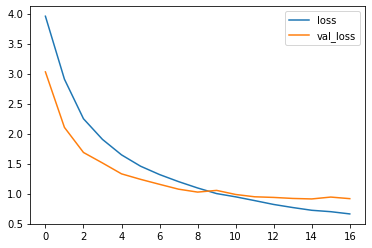

In [19]:
# Evaluation
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [20]:
# Run model on test set
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [21]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 76%


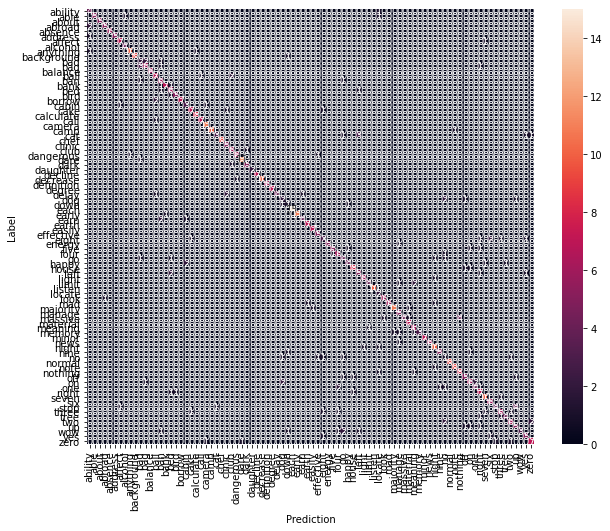

In [22]:
# Confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

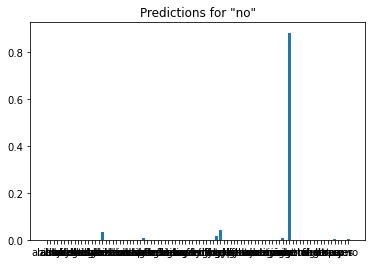

In [23]:
# Sample prediction
sample_file = data_dir/'no/no (1).wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [24]:
#model.save("CNN_model.h5")